# Реализация метода ближайших соседей

In [1]:
import numpy as np
import sklearn 
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
EPS = 1e-5 # для взвешенного метода

Метод $k$-ближайших соседей (k-NN) - метрический алгоритм для автоматической классификации объектов.
Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
- вычислить расстояние до каждого из объектов обучающей выборки;
- отобрать $k$ объектов обучающей выборки, расстояние до которых минимально;
- класс классифицируемого объекта — это класс, наиболее часто встречающийся среди $k$ ближайших соседей.

Реализуется класс KNNClassifier с методами:
- `__init__(self, k, strategy, metric, weights)` — конструктор класса;

-  `fit(self, X, y)` — обучение алгоритма;
- `find_kneighbors(self, X, return_distance)` — поиск соседей;

- `predict(self, X)` — предсказание на новых данных.

Есть собственная реализация метода ближайших соседей - 'my_own'.

In [12]:
import numpy as np
import sklearn 
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets

EPS = 1e-5


class KNNClassifier:
    def __init__(self, k, strategy, metric, weights):
        self.k = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        
    def fit(self, X, y):
        if self.strategy == 'brute':
            neigh = NearestNeighbors(n_neighbors=self.k, algorithm='brute', metric=self.metric)
            self.res_fit = neigh.fit(X,y)
            self.y = y
        elif self.strategy == 'kd_tree':
            neigh = NearestNeighbors(n_neighbors=self.k, algorithm='kd_tree', metric=self.metric)
            self.res_fit = neigh.fit(X,y)
            self.y = y
        elif self.strategy == 'ball_tree':
            neigh = NearestNeighbors(n_neighbors=self.k, algorithm='ball_tree', metric=self.metric)
            self.res_fit = neigh.fit(X,y)
            self.y = y
        elif self.strategy == 'my_own':
            self.X = X
            self.y = y
    
    def find_kneighbors(self, X_test, return_distance):
        if self.strategy == 'brute' or self.strategy == 'kd_tree' or self.strategy == 'ball_tree':
            self.dist, self.ind = self.res_fit.kneighbors(X_test)
            
        else:
            if self.metric == 'euclidean':
                dist = euclidean_distance(X_test, self.X)
            elif self.metric == 'cosine':
                dist = cosine_distance(X_test, self.X)
            else:
                 return print("Error metric")
            
            ind = np.argpartition(dist, self.k, axis = 1)
            dist = np.take_along_axis(dist, ind, axis = 1)
            dist = np.delete(dist, np.s_[self.k:], axis=1)
            ind = np.delete(ind, np.s_[self.k:], axis=1)
            ind_k = np.argsort(dist, axis=1)
            self.dist = np.take_along_axis(dist, ind_k, axis=1)
            self.ind = np.take_along_axis(ind, ind_k, axis=1)
            
        if return_distance:
            return self.dist, self.ind
        else:
            return self.ind
            
    def predict(self, X_test):
        if self.weights:
            self.dist, self.ind = self.find_kneighbors(X_test,True)
        else:
            self.ind = self.find_kneighbors(X_test,False)
        result = np.zeros(X_test.shape[0])
        for i in range(0, X_test.shape[0]):
            labels = np.zeros(len(np.unique(self.y)))
            for j in range(0,self.k):
                if self.weights:
                    labels[int(self.y[self.ind[i][j]])] += 1 / (self.dist[i][j] + EPS)
                else:
                    labels[int(self.y[self.ind[i][j]])] += 1 
            result[i] = np.argmax(labels)
        return result

Функции для вычисления расстояний

In [4]:
def euclidean_distance(x, y):
    sqr_x = np.array([np.sum(x * x, axis=1)])
    sqr_y = np.array([np.sum(y * y, axis=1)])
    x_y = np.dot(x,y.T)
    dist_x_y = sqr_x.T - 2 * x_y + sqr_y
    return np.sqrt(dist_x_y)

In [5]:
def cosine_distance(x, y):
    norm_x = np.array(np.linalg.norm(x, axis=1))
    norm_y = np.array(np.linalg.norm(y, axis=1))
    x_y = np.dot(x,y.T)
    matrix_cos = x_y / (np.dot(norm_x.reshape(-1, 1),norm_y.reshape(1,-1)))
    return 1 - matrix_cos

Функция для измерения качества на кросс-валидации с $3$ фолдами

In [6]:
from sklearn.model_selection import KFold

In [7]:
def accuracy(x, y):
        result = x.astype(int) - y.astype(int)
        zerous = result[result==0]
        return len(zerous) / len(y)  

In [8]:
def knn_cross_val_score(X, y, k_list, score, cv, **kwargs):
    result = {}
    if cv is not None:
        for k in k_list:
            item = KNNClassifier(k, **kwargs)
            accuracy_dict = []
            for i in cv:
                item.fit(X[i[0]],y[i[0]])
                y_pred = item.predict(X[i[1]])
                elem_accuracy = accuracy(y_pred, y[i[1]])
                accuracy_dict.append(elem_accuracy)
            result["{}".format(k)] = np.array(accuracy_dict)
    else: 
        fold = KFold(n_splits=3)
        for k in k_list:
            item = KNNClassifier(k, **kwargs)
            accuracy_dict = []
            for train, test in fold.split(X):
                item.fit(X[train],y[train])
                y_pred = item.predict(X[test])
                elem_accuracy = accuracy(y_pred, y[test])
                accuracy_dict.append(elem_accuracy)
            result["{}".format(k)] = np.array(accuracy_dict)
    return result

# Эксперименты на датасете MNIST.

In [9]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)

## 

Оценим по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) и время
работы $k$ ближайших соседей в зависимости от следующих факторов:
- $k$ от 1 до 10;
- используется евклидова или косинусная метрика.

Посмотрим на время работы при разных $k$ с метрикой = 'euclidean'.

In [13]:
from timeit import default_timer as timer

In [14]:
time = []
for k in range(1,11):
    start = timer()
    score_knn = knn_cross_val_score(X[0:5000], y[0:5000], [k], accuracy, cv=None,
                            **{'strategy': "my_own", "metric": "euclidean", "weights": True})
    end = timer()
    dif = end - start
    time.append(dif)
    print(k, dif, score_knn)
time = np.array(time)
time_mean = time.mean()
print(f"Среднее время работы: {time_mean}")

1 5.105148500000723 {'1': array([0.91181764, 0.9280144 , 0.92977191])}
2 4.956710200000089 {'2': array([0.91181764, 0.9280144 , 0.92977191])}
3 5.02041459999964 {'3': array([0.9160168 , 0.93821236, 0.92917167])}
4 4.980292600000212 {'4': array([0.91661668, 0.93641272, 0.93337335])}
5 4.986759000000347 {'5': array([0.91841632, 0.93461308, 0.92737095])}
6 4.9831851999997525 {'6': array([0.9160168 , 0.93581284, 0.92977191])}
7 5.040951900000437 {'7': array([0.9130174 , 0.93221356, 0.92076831])}
8 5.0415804000003845 {'8': array([0.91541692, 0.93221356, 0.92196879])}
9 5.0433175000007395 {'9': array([0.910018  , 0.92681464, 0.92016807])}
10 5.0016278000002785 {'10': array([0.91061788, 0.9310138 , 0.92136855])}
Среднее время работы: 5.015998770000261


Время работы при разных $k$ с метрикой = 'cosine'.

In [15]:
time_1 = []
for k in range(1,11):
    start = timer()
    score_knn = knn_cross_val_score(X[0:5000], y[0:5000], [k], accuracy, cv=None,
                                    **{'strategy': "my_own", "metric": "cosine", "weights": True})
    end = timer()
    dif = end - start
    time_1.append(dif)
    print(k, dif, score_knn)
time_1 = np.array(time_1)
time_mean_1 = time_1.mean()
print(f"Среднее время работы: {time_mean_1}")

1 4.906330400000115 {'1': array([0.9310138 , 0.9370126 , 0.93637455])}
2 4.9551477000004525 {'2': array([0.9310138 , 0.9370126 , 0.93637455])}
3 5.07080599999972 {'3': array([0.93521296, 0.94961008, 0.94177671])}
4 5.010312899999917 {'4': array([0.94061188, 0.95080984, 0.93697479])}
5 4.981564900000194 {'5': array([0.9370126 , 0.94421116, 0.93877551])}
6 4.981562300000405 {'6': array([0.93281344, 0.94481104, 0.93757503])}
7 5.022476000000097 {'7': array([0.92921416, 0.9340132 , 0.93637455])}
8 5.033993199999713 {'8': array([0.92981404, 0.93641272, 0.93577431])}
9 5.161804500000471 {'9': array([0.92681464, 0.93041392, 0.93637455])}
10 5.235629099999642 {'10': array([0.92321536, 0.93161368, 0.93817527])}
Среднее время работы: 5.035962700000073


Из результатов можно заметить, что косинусная мера дает более точный результат. В среднем время работы при евклидовой метрике получилось меньше. 

## 

Сравним взвешенный метод $k$ ближайших соседей c голосом объекта $\dfrac {1}{(distance + \varepsilon)}$, где $\varepsilon=10^{−5}$, с методом без весов при тех же фолдах и параметрах.

Для сравнения методов возьмем среднее по accuracy при каждом фиксированном $k$ и выберем максимум среди них, чтобы увидеть при каком $k$ более точное решение.

Метод без весов

In [16]:
max_of_k = []
for k in range(1,11):
    mean = np.mean(knn_cross_val_score(X[0:5000], y[0:5000], [k], accuracy,
            cv=None, **{'strategy': "my_own", "metric": "euclidean", 
                        "weights": False})["{}".format(k)])
    max_of_k.append(mean)
print(f"Лучшая итерация: {np.argmax(max_of_k) + 1} - {max(max_of_k)}")

Лучшая итерация: 1 - 0.9232013141189289


Взвешенный метод

In [17]:
max_of_k = []
for k in range(1,11):
    mean = np.mean(knn_cross_val_score(X[0:5000], y[0:5000], [k], accuracy,
            cv=None, **{'strategy': "my_own", "metric": "euclidean", 
                        "weights": True})["{}".format(k)])
    max_of_k.append(mean)
print(f"Лучшая итерация: {np.argmax(max_of_k) + 1} - {max(max_of_k)}")

Лучшая итерация: 4 - 0.9288009144869706


Видим, что взвешенный метод дал более точный результат, в первом случае наибольшее accuracy получилось при $k=1$, во втором - при $k=4$.

## 

Из предыдущего пункта выяснили, что лучшие параметры для модели: $k = 4$, metric = 'cosine', weights = True

In [18]:
model = KNNClassifier(4, 'my_own', 'cosine', True)

Возьмем обучающую выборку размером 5000 и посмотрим на результат.

In [19]:
model.fit(X[:5000],y[:5000])

In [20]:
y_pred = model.predict(X[5000:6000])

In [21]:
res = accuracy(y_pred, y[5000:6000])

In [22]:
res

0.945

Точность получилась выше, чем в кросс-валидации, наверное, это связано с тем, что в кросс-валидации меньше обучающая выборка.

## 

Построим матрицу ошибок (confusion matrix).

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Используем функцию для ее отображения

In [24]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
 
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
 
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [25]:
class_names = np.array(["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])

<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

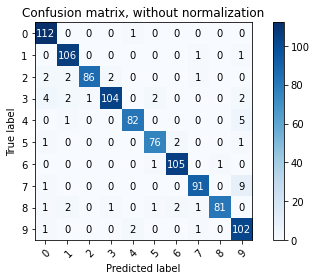

In [26]:
plot_confusion_matrix(y[5000:6000].astype(int), y_pred, class_names)

Из матрицы можно увидеть, что алгоритм чаще всего путал 7 с 9, предсказывал 9 вместо 7 (9 раз ошибся), также 4 раза перепутал 3 с 0.

Были допущены ошибки:

In [27]:
error = np.where(y_pred != y[5000:6000].astype(int))

In [28]:
error

(array([  0,  30,  38,  42,  68, 103, 113, 127, 134, 148, 174, 188, 195,
        216, 298, 308, 315, 332, 382, 390, 408, 422, 430, 480, 482, 536,
        554, 572, 616, 628, 632, 638, 642, 659, 666, 679, 704, 706, 723,
        736, 738, 740, 769, 795, 811, 821, 828, 842, 855, 896, 916, 936,
        954, 967, 972], dtype=int64),)

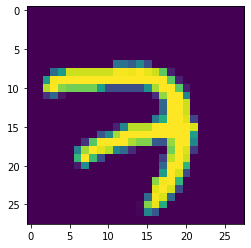

In [29]:
plt.imshow(X[5000,:].reshape(28,28))

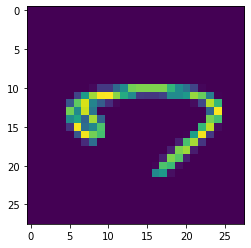

In [30]:
plt.imshow(X[5068,:].reshape(28,28))

Здесь, возможно, перепутал с 9.

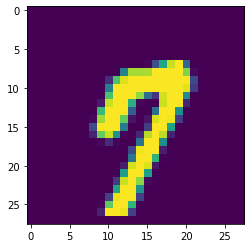

In [31]:
plt.imshow(X[5811,:].reshape(28,28))

В этом случае непонятно 1, 7 или 9.